# Bike Sharing Demand Modeling

# 1. Baseline pre-processing code

In [1]:
import pandas as pd
# 데이터 경로
data_path = '/kaggle/input/bike-sharing-demand/'

train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sampleSubmission.csv')

## 1. 피처 엔지니어링

### 이상치 제거

In [2]:
# 훈련 데이터에서 weather가 4가 아닌 데이터만 추출
train = train[train['weather'] != 4]

### 데이터 합치기

In [3]:
all_data = pd.concat([train, test], ignore_index=True)
all_data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5.0,27.0,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3.0,10.0,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
17373,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17374,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17375,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,NaN,NaN
17376,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,NaN,NaN


### 데이터 합치기

In [4]:
from datetime import datetime

# 날짜 피처 생성
all_data['date'] = all_data['datetime'].apply(lambda x: x.split()[0])
# 연도 피처 생성
all_data['year'] = all_data['datetime'].apply(lambda x: x.split()[0].split('-')[0])
# 월 피처 생성
all_data['month'] = all_data['datetime'].apply(lambda x: x.split()[0].split('-')[1])
# 시 피처 생성
all_data['hour'] = all_data['datetime'].apply(lambda x: x.split()[1].split(':')[0])
# 요일 피처 생성
all_data["weekday"] = all_data['date'].apply(lambda dateString : datetime.strptime(dateString,"%Y-%m-%d").weekday())

### 필요 없는 피처 제거

In [5]:
drop_features = ['casual', 'registered', 'datetime', 'date', 'month', 'windspeed']

all_data = all_data.drop(drop_features, axis=1)

### 데이터 나누기

In [6]:
# 훈련 데이터와 테스트 데이터 나누기
X_train = all_data[~pd.isnull(all_data['count'])]
X_test = all_data[pd.isnull(all_data['count'])]

# 타깃값 count 제거
X_train = X_train.drop(['count'], axis=1)
X_test = X_test.drop(['count'], axis=1)

y = train['count'] # 타깃값

## 2. 평가지표 계산 함수 작성

In [7]:
import numpy as np

def rmsle(y_true, y_pred, convertExp=True):
    # 지수변환
    if convertExp:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)
        
    # 로그변환 후 결측값을 0으로 변환
    log_true = np.nan_to_num(np.log(y_true+1))
    log_pred = np.nan_to_num(np.log(y_pred+1))
    
    # RMSLE 계산
    output = np.sqrt(np.mean((log_true - log_pred)**2))
    return output

<br>

# 2. 성능 개선 I : 릿지 회귀 모델

지금부터는 사이킷런이 제공하는모델 중 세 가지(릿지ridge, 라쏘lasso, 랜덤 포레스트random forest 회귀)를 더 다뤄보며 가장 우수한모델이 무엇인지 알아보겠습니다.

먼저 릿지 회귀 모델입니다.

릿지 회귀 모델은 L2 규제를 적용한 선형 회귀 모델입니다. 규제(regularization)란 모델이 훈련 데이터에 과대적합(overfitting) 되지 않도록 해주는 방법입니다. 훈련 데이터에 과대적합되면 모델이 훈련 데이터에만 너무 잘 들어맞고, 테스트 데이터로는 제대로 예측하지 못합니다. 따라서 모델이 과대적합되지 않게 훈련하는 게 중요합니다. 규제는 이럴 때 사용하는 방법입니다.

릿지 회귀 모델은 성능이 좋은 편은 아닙니다. 캐글러도 잘 쓰지 않습니다. 단순 선형 회귀 모델보다 과대적합이 적은 모델 정도로 생각하면 됩니다.

성능 개선 프로세스는 베이스라인 모델 때와 비슷합니다.

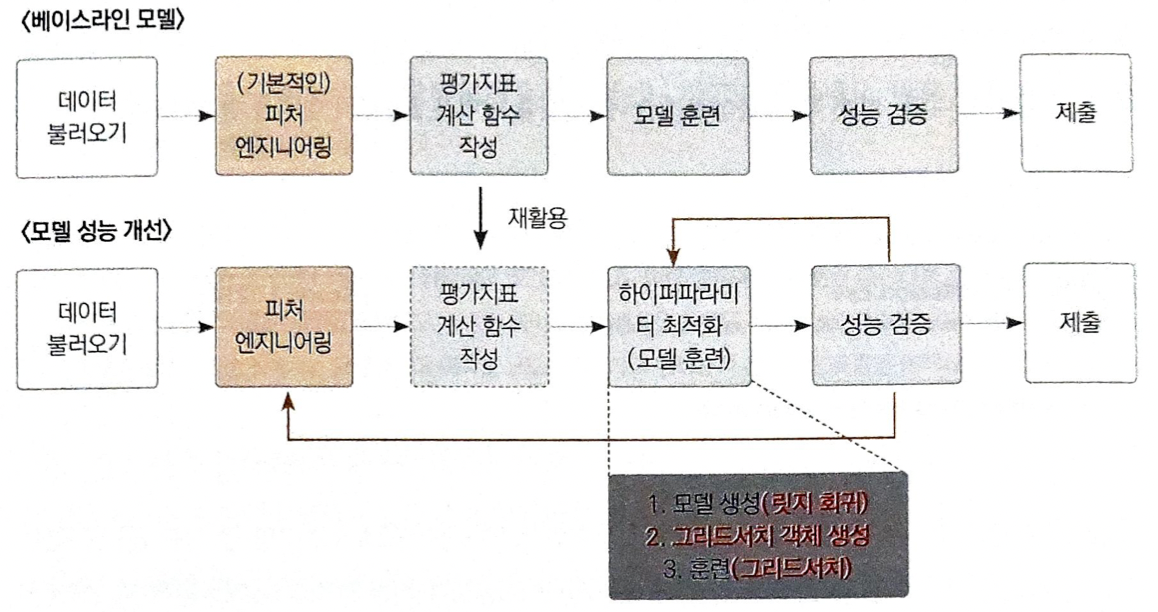

보다시피 피처 엔지니어링을 본격적으로 수행하며 모델 훈련 단계에서 하이퍼파라미터를 최적화합니다. 그리고 성능이 만족스럽지 못하면 피처 엔지니어링이나 하이퍼파라미터 최적화를 더 고민해봅니다.

이번 장은 튜토리얼이므로 피처 엔지니어링을 추가로 진행하진 않겠습니다. 그러니 평가지표 계산 함수 작성 단계까지는 베이스라인 모델과 똑같습니다.

## 1. 하이퍼파라미터 최적화(모델 훈련)

이번에는 '모델 훈련' 단계에서 그리드서치 기법을 사용할 것입니다. 그리드서치(grid search)는 하이퍼파라미터를 격자(grid) 처럼 촘촘하게 순회하며 최적의 하이퍼파라미터 값을 찾는 기법입니다. 각 하이퍼파라미터를 적용한 모델마다 교차 검증(cross-validation)하며 성능을 측정하여 최종적으로 성능이 가장 좋았을 때의 하이퍼파라미터 값을 찾아줍니다.

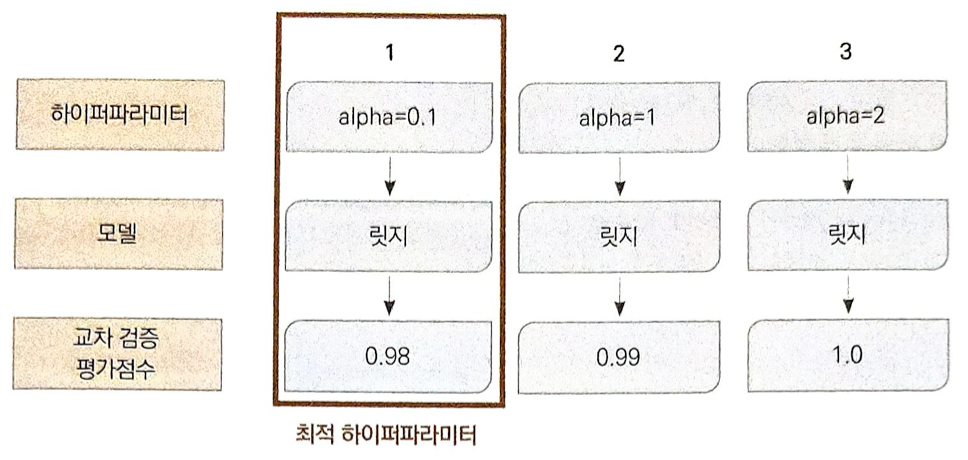

교차 검증 평가점수는 보통 에러 값이기 때문에 낮을수록 좋습니다. 즉, 이 그림에서는alpha=0.1일 때 평가점수가 가장 좋습니다. 따라서 최적 alpha 값은 0.1입니다(alpha는 릿지모델의 파라미터입니다).

그리드서치를 이용하지 않으면 alpha에 0.1, 1, 2 등의 값을 전달하여 교차 검증으로 모델 성능을 각각 측정해야 합니다. 수작업으로 하나하나 수행한 뒤 최적 하이퍼파라미터를 찾아야 하니 무척 번거롭습니다. 특히 하이퍼파라미터의 개수가 하나 늘어날 때마다 번거로움은 기하급수적으로커질 것입니다. 그리드서치는 이 일을 자동으로 해줍니다. 테스트하려는 하이퍼파라미터와 값의범위만 전달하면 알아서 모든 가능한 조합을 순회하며 교차 검증합니다.

그리드서치가 추가되면서 하이퍼파라미터 최적화 절차는 다음 그림처럼 세분화됩니다.

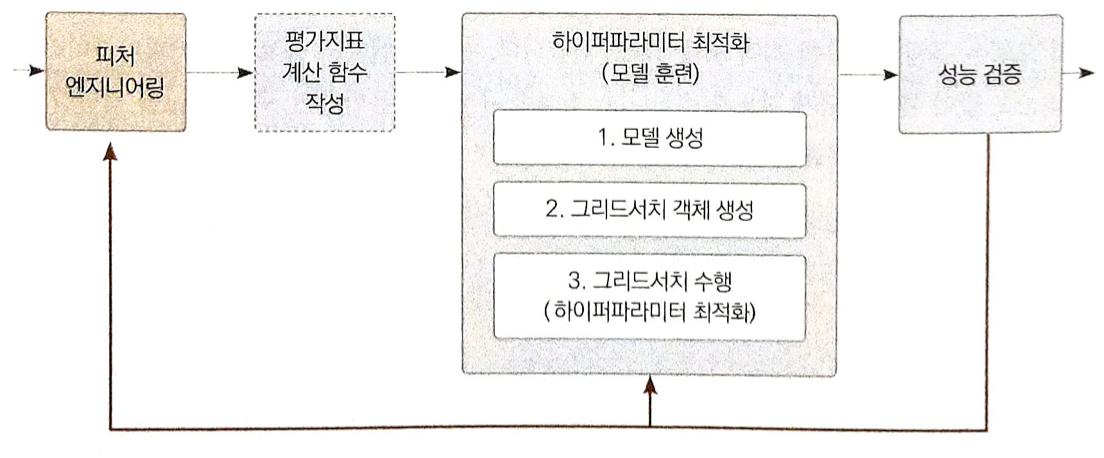

이제 그리드서치로 최적의 릿지 회귀 모델을 찾아내는 코드를 살펴봅시다.

### 모델 생성

가장 먼저 릿지 모델을 생성합니다.


In [8]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

ridge_model = Ridge()

특별한 것 없이 사이킷런의 기본 릿지 모델을 생성했습니다. 새로 추가된 임포트문들은 이어지는 단계에서 사용합니다.

### 그리드서치 객체 생성

이어서 그리드서치 객체를 생성합니다. 앞서 그리드서치는 '하이퍼파라미터의 값'을 바꿔가며 '모델'의 성능을 교차 검증으로 '평가'해 최적의 하이퍼파라미터 값을 찾아준다고 했습니다. 이 말은 그리드서치 객체가 다음의 세 가지를 알고 있어야 한다는 뜻입니다.
1. 비교 검증해볼 하이퍼파라미터 값 목록
2. 대상 모델
3. 교차 검증용 평가수단(평가 함수)

대상 모델은 앞서 만들었으니, 하이퍼파라미터 값 목록과 평가 함수만 더 준비하면 됩니다.

릿지 모델은 규제를 적용한 회귀 모델이라고 했습니다. 릿지 모델에서 중요한 하이퍼파라미터는 alpha로, 값이 클수록 규제 강도가 세집니다. 적절한 규제를 적용한다면, 즉 alpha를 적당한 크기로 하면 과대적합 문제를 개선할 수 있습니다.

In [9]:
# 하이퍼 파라미터 값 목록
ridge_params = {'max_iter':[3000], 'alpha':[0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000]}

# 교차 검증용 평가 함수(RMSLE 점수 계산)
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)

# 그리드서치(with 릿지) 객체 생성
gridsearch_ridge_model = GridSearchCV(estimator=ridge_model,   # 릿지 모델
                                      param_grid=ridge_params, # 값 목록
                                      scoring=rmsle_scorer,    # 평가지표
                                      cv=5)                    # 교차검증 분할 수

그리드서치 객체를 생성하는 `GridSearchCV()` 함수의 주요 파라미터는 다음과 같습니다.
* estimator : 분류 및 회귀 모델
* param_grid : 딕셔너리 형태로 모델의 하이퍼파라미터명과 여러 하이퍼파라미터 값을 지정
* scoring : 
    * 평가지표.
    * 사이킷에서 기본적인 평가지표를 문자열 형태로 제공함.
        * 예를 들어, 정확도는 'accuracy', F1 점수는 'fl’, ROC-AUC는 'roc_auc', 재현율은 'recall'로 표시함.
    * 사이킷런에서 제공하는 평가지표를 사용하지 않고 별도로 만든 평가지표를 사용해도 됨.
        * 앞의 코드에서는 mertics.make_scorer를 활용해 별도로 만든 평가지표를 사용.
        * make_scorer는 평가지표 계산함수와 평가지표 점수가 높으면 좋은지 여부 등을 인수로 받는 교차검증용 평가 함수임
* cv : 교차 검증 분할 개수(기본값은 5)

한편 하이퍼파라미터 값 목록에서 max_iter는 3000으로 고정했고, alpha는 0.1에서 1000까지 다양합니다. 그리드서치 객체는 param_grid로 전달된 모든 하이퍼파라미터를 대입해 교차 검증으로 모델 성능 점수를 계산하여 어떤 값일 때 점수가 가장 좋은지 찾아줍니다. 하지만 모든 값에 대해 교차 검증 개수만큼 훈련 및 평가하므로 시간이 오래 걸립니다. 예시 코드에서는 데이터가 적고 모델이 단순해서 괜찮습니다만, 데이터가 많고 복잡한 모델을 사용하면 GridSearchCV의 수행 시간은 상당히 길어집니다.

### 그리드서치 수행

다음은 방금 만든 그리드서치 객체를 이용하여 그리드서치를 수행합니다.

In [10]:
log_y = np.log(y) # 타깃값 로그변환
gridsearch_ridge_model.fit(X_train, log_y) # 훈련(그리드서치)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400,
                                   800, 900, 1000],
                         'max_iter': [3000]},
             scoring=make_scorer(rmsle, greater_is_better=False))

코드가 일관되도록 그리드서치 객체도 모델 객체와 똑같이 `fit()` 메서드를 제공합니다. `fit()` 을 실행하면 객체 생성 시 param_grid에 전달된 값들을 순회하면서 교차 검증으로 평가지표 점수를 계산합니다. 이때 가장 좋은 성능을 보인 값을 `best_params_` 속성에 저장하며, 이 최적 값으로 훈련한 모델(최적 예측기)을 `best_estimator_` 속성에 저장합니다.

그렇다면 최적 하이퍼파라미터로는 어떤 값이 선정되었는지 살펴봅시다.

In [11]:
print('최적 하이퍼파라미터 :', gridsearch_ridge_model.best_params_)

최적 하이퍼파라미터 : {'alpha': 0.1, 'max_iter': 3000}


출력 결과를 보면 alpha가 0.1이고 max_iter가 3000일 때 가장 좋은 성능을 낸다는 사실을 알 수 있습니다.

<br>

## 2. 성능 검증

이후 과정은 간단하니 한꺼번에 진행하겠습니다.

그리드서치를 완료하고 나면 그리드서치 객체의 `best_estimator_` 속성에 최적 예측기가 저장되어 있습니다. 따라서 예측은 그리드서치 객체의 `best_estimator_` 속성에 저장된 모델로 수행하면 됩니다.

In [12]:
# 예측
preds = gridsearch_ridge_model.best_estimator_.predict(X_train)

# 평가
print(f'릿지 회귀 RMSLE 값 : {rmsle(log_y, preds, True):.4f}')

릿지 회귀 RMSLE 값 : 1.0205


<br>

# 3. 성능 개선 II : 라쏘 회귀 모델

라쏘 회귀 모델은 L1 규제를 적용한 선형 회귀 모델입니다. 앞 절에서 다룬 릿지 회귀 모델과 마찬가지로 성능이 좋은 편은 아니라서 캐글러들이 잘 쓰지 않습니다. 달리 말하자면, 나중에 여러분이 직접 만드는 모델은 적어도 릿지나 라쏘보다는 성능이 좋아야 할 것입니다.

이번 대회의 문제에서 라쏘 회귀 모델이 어느 정도의 성능을 보이는지 측정해보겠습니다.

## 1. 하이퍼파라미터 최적화(모델 훈련)

사용한 모델과 파라미터만 다를 뿐 릿지 회귀 때와 똑같은 흐름입니다(rmsle_scorer 함수는 릿지 회귀 때 정의한 것을 재활용했습니다). 릿지 회귀와 마찬가지로 alpha는 규제 강도를 조정하는 파라미터입니다.

In [13]:
from sklearn.linear_model import Lasso

# 모델 생성
lasso_model = Lasso()

# 하이퍼파라미터 값 목록
lasso_alpha = 1/np.array([0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000])
lasso_params = {'max_iter':[3000], 'alpha':lasso_alpha}

# 그리드서치(with 라쏘) 객체 생성
gridsearch_lasso_model = GridSearchCV(estimator=lasso_model,
                                      param_grid=lasso_params,
                                      scoring=rmsle_scorer,
                                      cv=5)

# 그리드서치 수행
log_y = np.log(y)
gridsearch_lasso_model.fit(X_train, log_y)

print('최적 하이퍼파라미터 :', gridsearch_lasso_model.best_params_)

최적 하이퍼파라미터 : {'alpha': 0.00125, 'max_iter': 3000}


<br>

## 2. 성능 검증

그리드서치로 찾은 최적 예측기로 예측하여 RMSLE 값을 확인해보겠습니다.

In [14]:
# 예측
preds = gridsearch_lasso_model.best_estimator_.predict(X_train)

# 평가
print(f'라쏘 회귀 RMSLE 값 : {rmsle(log_y, preds, True):.4f}')

라쏘 회귀 RMSLE 값 : 1.0205


결과를 보면 RMSLE 값은 1.02로, 여전히 개선되지 않았습니다. 그래서 이번에도 결과 제출은 생략하겠습니다.

<br>

# 4. 성능 개선 III : 랜덤 포레스트 회귀 모델

마지막으로 랜덤 포레스트 회귀 모델을 사용해보겠습니다. 랜덤 포레스트 회귀는 간단히 생각하면 훈련 데이터를 랜덤하게 샘플링한 모델 n개를 각각 훈련하여 결과를 평균하는 방법입니다.

역시 앞서 살펴본 릿지 회귀, 라쏘 회귀와 같은 흐름입니다.

## 1. 하이퍼파라미터 최적화(모델 훈련)

랜덤 포레스트 회귀 모델로 그리드서치를 수행하고 최적 하이퍼파라미터 값까지 출력해보겠습니다.

In [15]:
from sklearn.ensemble import RandomForestRegressor

# 모델 생성
randomforest_model = RandomForestRegressor()

# 그리드서치 객체 생성
rf_params = {'random_state':[42], 'n_estimators':[100, 120, 140]}
gridsearch_random_forest_model = GridSearchCV(estimator=randomforest_model,
                                              param_grid=rf_params,
                                              scoring=rmsle_scorer,
                                              cv=5)

# 그리드서치 수행
log_y = np.log(y)
gridsearch_random_forest_model.fit(X_train, log_y)

print('최적 하이퍼파라미터 :', gridsearch_random_forest_model.best_params_)

최적 하이퍼파라미터 : {'n_estimators': 140, 'random_state': 42}


그리드서치를 수행할 때 사용한 랜덤 포레스트 회귀 모델의 파라미터는 random_state와 n_estimators입니다. random_state는 랜덤 시드값으로, 값을 명시하면 코드를 다시 실행해도 같은 결과를 얻을 수 있습니다. n_estimators는 랜덤 포레스트를 구성하는 결정 트리 개수를 의미합니다.

랜덤 포레스트부터는 그리드서치에 시간이 좀 걸립니다.

<br>

## 2. 성능 검증

최적 예측기의 성능을 확인해보죠.

In [16]:
# 예측
preds = gridsearch_random_forest_model.best_estimator_.predict(X_train)

# 평가
print(f'랜덤 포레스트 회귀 RMSLE 값 : {rmsle(log_y, preds, True):.4f}')

랜덤 포레스트 회귀 RMSLE 값 : 0.1127


랜덤 포레스트 회귀 모델을 사용하니 RMSLE 값이 큰 폭으로 개선되었네요. 선형 회귀, 릿지 회귀, 라쏘 회귀 모델의 RMSLE 값은 모두 1.02였습니다. 반면 랜덤 포레스트 회귀 모델은 0.11입니다(값이 작을수록 좋습니다). 네 모델 중 성능이 가장 좋은 모델은 랜덤 포레스트입니다.


<br>

## 3. 예측 및 결과 제출

이제 성능이 가장 좋은 모델의 예측 결과를 제출하면 경진대회가 모두 끝이 납니다. 검증 결과 랜덤 포레스트 회귀 모델의 성능이 가장 좋았습니다. 물론 성능 측정을 훈련 데이터로 했기 때문에 테스트 데이터에서도 성능이 좋다고 보장할 수는 없습니다. 다행히 본 경진대회는 훈련 데이터와 테스트 데이터의 분포가 비슷합니다. 두 데이터 분포가 비슷하면 과대적합 문제가 상대적으로 적기 때문에 훈련 데이터에서 성능이 좋다면 테스트 데이터에서도 좋을 가능성이 큽니다.

그러면 훈련 데이터 타깃값과 테스트 데이터 타깃 예측값의 분포를 살펴보겠습니다. histplot()으로 분포도(히스토그램)를 그려보죠. histplot() 함수는 ax 파라미터를 사용해 여러 축에 그래프를 그릴 수 있습니다.


그러면 훈련 데이터 타깃값과 테스트 데이터 타깃 예측값의 분포를 살펴보겠습니다. `histplot()` 으로 분포도(히스토그램)를 그려보죠. `histplot()` 함수는 ax 파라미터를 사용해 여러 축에 그래프를 그릴 수 있습니다.

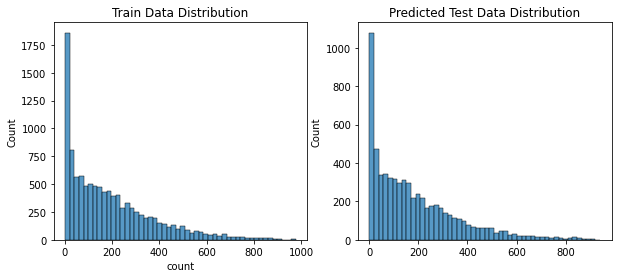

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

randomforest_preds = gridsearch_random_forest_model.best_estimator_.predict(X_test)

figure, axes = plt.subplots(ncols=2)
figure.set_size_inches(10, 4)

sns.histplot(y, bins=50, ax=axes[0])
axes[0].set_title('Train Data Distribution')

sns.histplot(np.exp(randomforest_preds), bins=50, ax=axes[1])
axes[1].set_title('Predicted Test Data Distribution');

보다시피 두 데이터의 분포가 비슷합니다.

랜덤 포레스트로 예측한 결과를 파일로 저장하고, 커밋 후 제출해보세요.

In [18]:
submission['count'] = np.exp(randomforest_preds) # 지수변환
submission.to_csv('submission.csv', index=False)

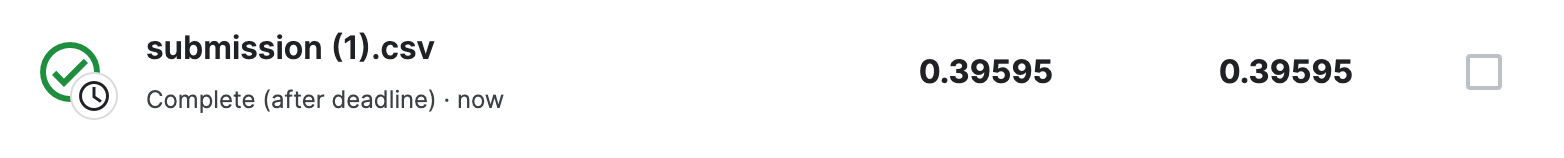

제출 결과 평가점수는 0.39595입니다. 이 점수면 등수가 193등으로, 상위 6.0%입니다(베이스라인 모델은 상위 85.5%였습니다). 상위 10%까지 동메달이므로 동메달을 딸 수 있는 등수군요. 단, 본 대회는 플레이그라운드 대회이기 때문에 메달이 수여되지는 않습니다. 이처럼 간단한 피처엔지니어링과 기본 모델로도 꽤 높은 등수를 기록할 수 있습니다.